In [14]:
from pathlib import Path
import pandas as pd

# file = Path("/home/piotr/Documents/mgr/uwb-rs/data-processing/data/2023-05-21-20:43:13.145050P4-h.csv")
# file = Path("data/p1/2023-07-04-22:19:21.918974living-room-p1-27.csv")
file = Path("/home/piotr/Documents/mgr/uwb-rs/data-processing/2023-08-23-18:01:36.383219release.csv")



df = pd.read_csv(file)
df["timestamp"] = pd.to_datetime(df["timestamp"])

df["time_diff"] = df["timestamp"].diff()
mean = df["time_diff"].mean()
T = float(mean.to_timedelta64())/10**9
print(f"Mean dt = {T}s")
print(f"Freq = {1/T}")

Mean dt = 0.128389729s
Freq = 7.788785035912023


In [8]:
from locator import *
from data.points import ANCHORS
positions = ANCHORS

import time

# del positions["0x5836"]

data = pd.read_csv(file)

data = data[["anchor", "distance"]]
df = data.groupby("anchor").mean()


df = df[df.index.isin(positions.keys())]

display(df)

anchors = [Anchor(name, positions.get(name)) for name in df.index.to_list()]
distances = df["distance"].to_list()

performance = dict()
# Mierzymy po 1000 próbek, jednostka to sekundy, nie skalujemy więc mamy milisekundy

# MSE multilateration
start = time.perf_counter()
for _ in range(1000):
    ret = trilateration(distances, anchors).x
stop = time.perf_counter()
ret = Point(*ret)
performance["Błąd średniokwadratowy"] = (stop-start)

# Circle multilateration
from multilateration.solver_2d import Multilateration2D
from multilateration.geometry import Circle

mlat = Multilateration2D([Circle.from_coords(a.position[0], a.position[1], d) for a, d in zip(anchors, distances)])
start = time.perf_counter()
for _ in range(1000):
    ret = Multilateration2D.solve(mlat).center
stop = time.perf_counter()
performance["Równanie okręgu"] = (stop-start)

# Sphere multilateration
from multilateration.solver_3d import Multilateration3D
from multilateration.geometry import Sphere

mlat = Multilateration3D([Sphere.from_coords(a.position[0], a.position[1], 0, d) for a, d in zip(anchors, distances)])
start = time.perf_counter()
for _ in range(1000):
    ret = Multilateration3D.solve(mlat).center
stop = time.perf_counter()
performance["Równanie sfery"] = (stop-start)

,distance
anchor,
0x26bd,3781.389620
0x5601,2919.776526
0x5836,3607.068844
0x6c0d,2828.814788


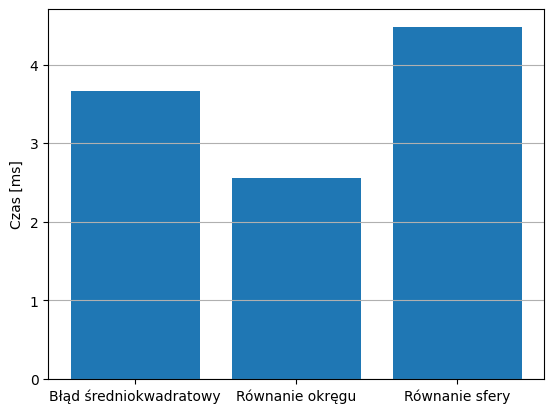

In [9]:
import matplotlib.pyplot as plt

plt.bar(performance.keys(), performance.values())
plt.ylabel("Czas [ms]")
plt.grid(True, axis="y")

In [10]:
# import plotly.express as px

df.reset_index(inplace=True)
df["x"] =  df["anchor"].transform(lambda v: positions.get(v)[0])
df["y"] =  df["anchor"].transform(lambda v: positions.get(v)[1])


,anchor,distance,x,y
0,0x26bd,3781.389620,3400,4350
1,0x5601,2919.776526,3400,0
2,0x5836,3607.068844,-200,4350
3,0x6c0d,2828.814788,0,0


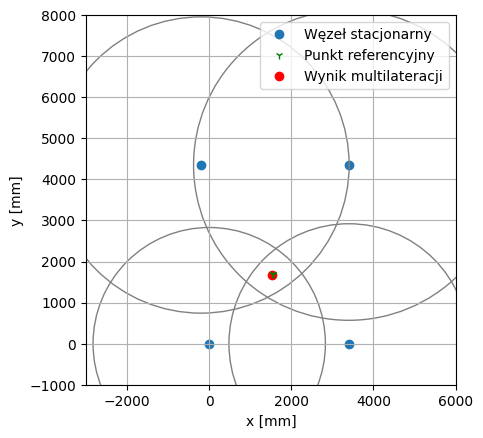

In [11]:
from data.points import TAG

fig, ax = plt.subplots()
ax.scatter(df["x"], df["y"])
ax.set(xlim=(-3000,6000), ylim=(-1000,8000))
display(df)
for _, data in df.iterrows():
    circle = plt.Circle( (data.x, data.y),
                        data.distance,
                        fill = False,
                        color="grey")
    ax.set_aspect(1)
    ax.add_artist(circle)

ax.scatter(ret[0], ret[1], color="red")
ax.add_artist(plt.Circle(ret, ))
plt.scatter(*TAG["P1"], marker="1", c="g")
plt.grid()
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")

custom_legend_handles = [plt.Line2D([], [], linestyle='None', marker="o", color='tab:blue', label='Węzeł stacjonarny'),
                         plt.Line2D([], [], linestyle='None', marker="1", color="g", label="Punkt referencyjny"),
                         plt.Line2D([], [], linestyle='None', marker="o", color="r", label="Wynik multilateracji")]
custom_legend_labels = [handle.get_label() for handle in custom_legend_handles]

# Add the custom legend to the plot
plt.gca().legend(handles=custom_legend_handles, labels=custom_legend_labels, loc='upper right')

plt.show()

In [12]:
def distance(p1:Point ,p2: Point):
    ax, ay = p1.x, p1.y
    bx, by = p2.x, p2.y
    return sqrt((bx - ax) ** 2 + (by - ay) ** 2)

distance(ret, Point(*TAG["P1"]))

30.533876427494253